# Application to neural data

In [18]:
import jax 

from mixedsde.fit import *
from mixedsde.simulation import *
from mixedsde.model_class import * 
from mixedsde.data_processing import *

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, conversion, r
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon, gamma, weibull_min, lognorm, probplot

## Data processing

We use the neural data provided as an example in several `R` packages, including `mixedsde`. The dataset consists of `N=240` trajectories of membrane potentials, each containing `n=2000` points spaced by a time step of `h=0.00015` seconds. This dataset has been the subject of several published analyses, in which the authors primarily employed Ornstein-Uhlenbeck processes with Gaussian random effects and fixed effects in the drift, along with a constant diffusion coefficient.

In [19]:
conversion.set_conversion(pandas2ri.converter)

r('load("neuronal.data.rda")')
r_obj = r['neuronal.data']
y_init = list(r_obj[0])
time = list(r_obj[1])

Before the analysis, we scale the signal by multiplying the membrane potential measurements by a factor of `200`. The aim is to make visible an inter-trajectory variability that would otherwise be challenging to discern.

In [20]:
y = jax.numpy.array(y_init) * 200
times = jax.numpy.array(time)
h = 0.00015

nb_trajectories = y.shape[0]
time_mat = jax.numpy.tile(times, (nb_trajectories, 1))

The following graph shows the dynamics observed in the data.

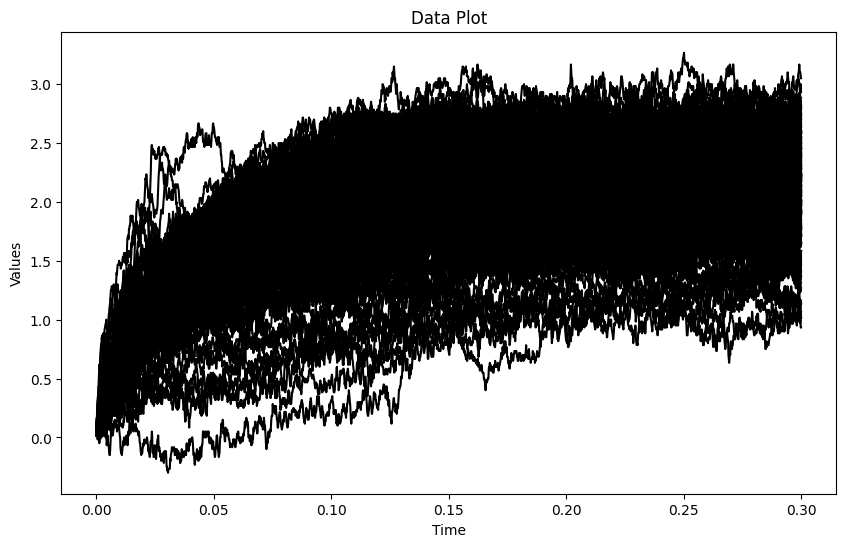

In [21]:
plt.figure(figsize=(10, 6))
for i in range(y.shape[0]):
    plt.plot(
        time_mat[0,:], jax.numpy.array(y[i, :]), color="black", linewidth=1.5
    )
    
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Data Plot")
plt.show()


## Model definition

First, we define the structure of the model. Important points are the definition of the drift function and the diffusion coefficient. For drift, we decide to retain the drift form of an Ornstein-Uhlenbeck, the model used in all analyses we know of for these neuronal data. 

In [22]:
def a(y, time):
    a_value = jax.numpy.array(
        [y  / jax.numpy.sqrt(1 + 0 * y * y), 1.0 /
         jax.numpy.sqrt(1 + 0 * y * y) + 0.0 * time]
    )
    return a_value

For the diffusion coefficient, we use the following function, which is constant if the fixed effect is 0.

In [23]:
def c(y, eta, time):
    c_value = jax.numpy.sqrt(1 + eta * y * y) + 0.0 * time
    return c_value

The model is thus as follows:
$$
dY_i = \tau_i \left(\varphi_{i1} + \varphi_{i2} Y_i\right) dt + \sqrt{\tau_i} \sqrt{1 + \eta Y_i^2} dW_i
$$

As shown below, the weibull distribution with offset seems to best match the empirical distribution of the $\hat{\tau}_i$. No parameter values are needed to define the model here, as it is used for estimation.

In [24]:
key = jax.random.PRNGKey(0)

eta = jax.numpy.array([0.0])

theta_tau = {
    'weibull_loc': {'loc': 'N/A', 'shape': 'N/A', 'scale': 'N/A'}, 
}

theta_phi = {
    'normal': {'mu': jax.numpy.array([0.0,0.0]), 'omega2': jax.numpy.array([[0.0,0.0],[0.0,0.0]])} 
} 

m1 = Mixedsde(drift_func=a,diffusion_func=c,drift_re_param=theta_phi['normal'],diffusion_fixed_effect=eta, diffusion_re_dist='weibull_loc',diffusion_re_param=theta_tau['weibull_loc']) 

## Parameter estimation

We choose a diagonal covariance matrix for the Gaussian random effects in the drift, and we provide initial values to the estimation function.

In [25]:
covariance_to_estimate=jax.numpy.array([[1.0,1.0],[1.0,1.0]],dtype=int)

init = {
    'diffusion': {
        'eta': jax.numpy.array([0.0]), 
        'theta_tau':  {'shape': 3.0, 'scale': 3.0, 'loc': 3.0}
        },
    'drift': {
        'mu': jax.numpy.array([-6.0,10.0]), 
        'omega2': jax.numpy.array([[1.0,0.0],[0.0,1.0]])
        } 
} 

eta_hat, theta_tau_hat, tau_hat, mu_hat, omega2_hat = m1.fit_mixed_sde(y,time_mat,init,covariance_to_estimate,method='joint')

We obtain the following parameter estimations:

In [26]:
print("Fixed effect in the diffusion coefficient", eta_hat.item())
print("Distribution of the random effects in the diffusion coefficient", theta_tau_hat)
print("Mean of the random effects in the drift", mu_hat)
print("Variance of the random effects in the drift")
print(omega2_hat)


Fixed effect in the diffusion coefficient -0.01266096904873848
Distribution of the random effects in the diffusion coefficient [3.44679   4.5920186 3.6994658]
Mean of the random effects in the drift [-4.8383517  9.769699 ]
Variance of the random effects in the drift
[[0.0387627  0.02753413]
 [0.02753413 2.14807   ]]


## Model adequacy

First, we check whether the estimated distribution and the empirical distribution of the estimated random effects of the diffusion coefficient coincide.

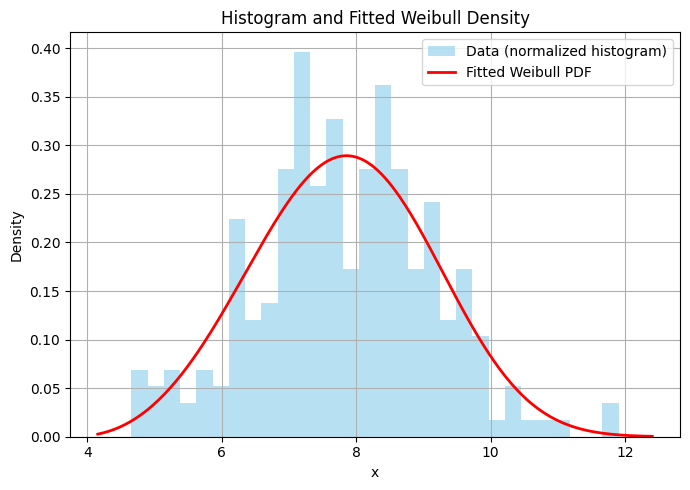

In [27]:
x_vals = jax.numpy.linspace(min(tau_hat) - 0.5, max(tau_hat) + 0.5, 300) 

def logpdf_weibull_ind(x, k, lam, loc):
                return (
                    (k - 1) * jax.numpy.log((x - loc) / lam)
                    - ((x - loc) / lam) ** k
                    + jax.numpy.log(k / lam)
                )

            
pdf_vals = jax.numpy.exp(logpdf_weibull_ind(x_vals, k=theta_tau_hat[0], lam=theta_tau_hat[1], loc=theta_tau_hat[2]))

plt.figure(figsize=(7,5))
plt.hist(tau_hat[:,-1], bins=30, density=True, alpha=0.6, color="skyblue", label="Data (normalized histogram)")
plt.plot(x_vals, pdf_vals, 'r-', lw=2, label="Fitted Weibull PDF")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Histogram and Fitted Weibull Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




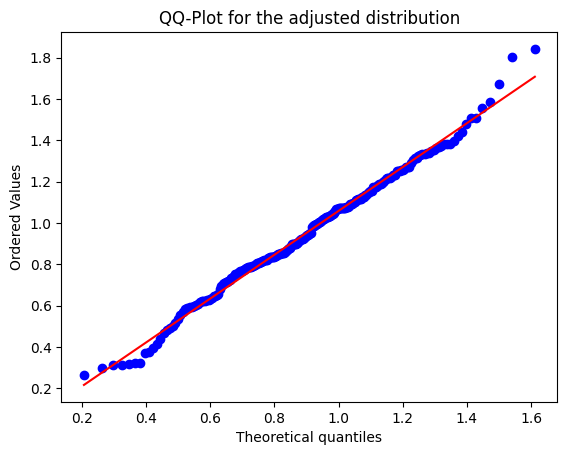

In [28]:
loc, shape, scale = weibull_min.fit(tau_hat)
weibull_transformed_tau_hat = (tau_hat[:,-1]-loc)/scale
probplot(weibull_transformed_tau_hat, dist="weibull_min", sparams=(shape,), plot=plt)
plt.title("QQ-Plot for the adjusted distribution")
plt.show()

Second, we compare trajectories simulated under the fitted model with the true trajectories. 

In [29]:


def drift(y, phi, tau):
    a_value =  phi[0] * y  + phi[1] 
    return tau * a_value

def diffusion(y, tau, eta):
    c_value = np.sqrt(tau)*np.sqrt(1 + eta * y * y) 
    return c_value

def simu(random, fixed, h, n, y0):
    y = np.zeros(n + 1)
    y[0] = y0
    phi = random[0:2]
    tau = random[2]
    eta = fixed[0]
   

    for j in range(n):
        y[j+1] = y[j] + drift(y[j], phi, tau) * h + diffusion(y[j],
                                                                    tau, eta) * np.random.normal(scale=np.sqrt(h))

    return y


def simu_joint(eta, theta_tau, mu, omega2, N, h, n, y0):
   
    shape, scale, loc = theta_tau 

    tau = (weibull_min.rvs(c=shape, size=N)) * scale  + loc 
    phi = np.random.multivariate_normal(mu, omega2, N)
    re = np.column_stack((phi, tau))
    
    y = np.zeros((N, n + 1))
    for i in range(N):
        y[i,:] = simu(random=re[i,:], fixed=eta, h=h, n=n, y0=y0) 

    return {'y': y, 'tau': tau, 'phi': phi}

In [30]:

y0 = jax.numpy.mean(y[:,0]).item()
h_euler = jax.numpy.mean(jax.numpy.diff(times)).item()
t0 = time[0]
t_max = time[-1]
n = y.shape[1]
nb_trajectories = 1000
simu = simu_joint(eta_hat, theta_tau_hat, mu_hat, omega2_hat, nb_trajectories, h, n, y0)


/Users/mdelattre/miniconda3/envs/mixedsde_py312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


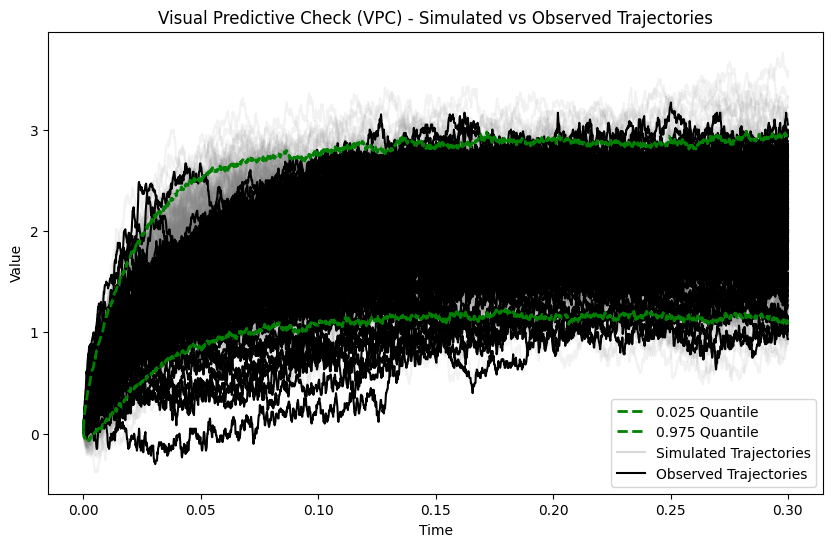

In [31]:
plt.figure(figsize=(10, 6))

# Calculation of quantiles of the simulated (theoretical) distribution for each time point
lower_quantile = np.quantile(simu['y'], 0.025, axis=0)
upper_quantile = np.quantile(simu['y'], 0.975, axis=0)

# Simulated (theoretical) trajectories in gray background
for i in range(500):
    plt.plot(np.arange(y.shape[1] + 1) * h, simu['y'][i, :], color='grey', alpha=0.1)

# Observed (real) trajectories in black foreground
for i in range(y.shape[0]):
    plt.plot(time, np.array(y[i, :]), color='black', linewidth=1.5)

# Quantile trajectories (0.025 and 0.975) in green
plt.plot(np.arange(y.shape[1] + 1) * h, lower_quantile, color='green', linestyle='--', linewidth=2, label='0.025 Quantile')
plt.plot(np.arange(y.shape[1] + 1) * h, upper_quantile, color='green', linestyle='--', linewidth=2, label='0.975 Quantile')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Visual Predictive Check (VPC) - Simulated vs Observed Trajectories')

plt.plot([], [], color='grey', alpha=0.3, label='Simulated Trajectories')
plt.plot([], [], color='black', linewidth=1.5, label='Observed Trajectories')
plt.legend()

plt.show()